In [1]:
from utilities import *
from model import *
from metrics import Metrics
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from tqdm import tqdm
import time
import multiprocessing
from sklearn import svm
from gensim.test.utils import get_tmpfile
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix as sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [40]:
# First we need to load all data for the Doc2Vec

file_dir_stanford = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data-tagged/aclImdb"

In [31]:
stanford_data = DataHandler(file_dir_stanford)
stanford_data.readStanfordData()

fetching /train/pos
fetching /train/neg
fetching /train/unsup
fetching /test/pos
fetching /test/neg


100%|██████████| 100000/100000 [02:06<00:00, 788.92it/s]


In [32]:
stanford_data = [StanfordDocument(words, [1]) for words in stanford_data.x_data]

In [33]:
cores = multiprocessing.cpu_count()
doc2vec_model = MyDoc2Vec(dm=0, vector_size=100, min_count=10, epochs=30, window=5, workers=cores, hs = 1)
doc2vec_model.train(stanford_data)
doc2vec_model.save("my_best_model")

# SVM


In [2]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
data = DataHandler(file_dir)

In [3]:
fname = "my_model"
doc2vec_model = MyDoc2Vec()
doc2vec_model.load(fname)

In [4]:
file_dir_our      = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data      = DataHandler(file_dir_our)
our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)


100%|██████████| 2008/2008 [00:06<00:00, 308.44it/s]


In [5]:
vector_data = DataHandler()
vector_data(DataHandler.applyDoc2Vec(cv_train.x_data, doc2vec_model.model), cv_train.y_data)
vector_data.roundRobinSplit(10)

In [35]:
svm_model = MySVM(gamma=0.01, kernel = 'rbf')

In [36]:
accuracies = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = 'rbf', C=1, cache_size=200, degree=3, gamma='auto',tol=0.001,shrinking=True, decision_function_shape = 'ovr')

100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


In [11]:
accuracies = Metrics.roundRobinCV(vector_data, 10, MySVM, gamma=0.002, kernel = 'rbf')

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


In [12]:
np.mean(np.array(accuracies))

0.85224719101123581

svm_model.train(vector_data.x_data, vector_data.y_data)
predictions = svm_model.predict(DataHandler.applyDoc2Vec(test.x_train, doc2vec_model.model))

In [39]:
test_accuracies = Metrics.getAccuracy(predictions, test.y_train)

In [40]:
test_accuracies

0.83

In [8]:
test_accuracies

0.815

# TSNE on vector_data

In [9]:
tsne = TSNE(n_components=3)

In [10]:
embedding = tsne.fit_transform(vector_data.x_data)

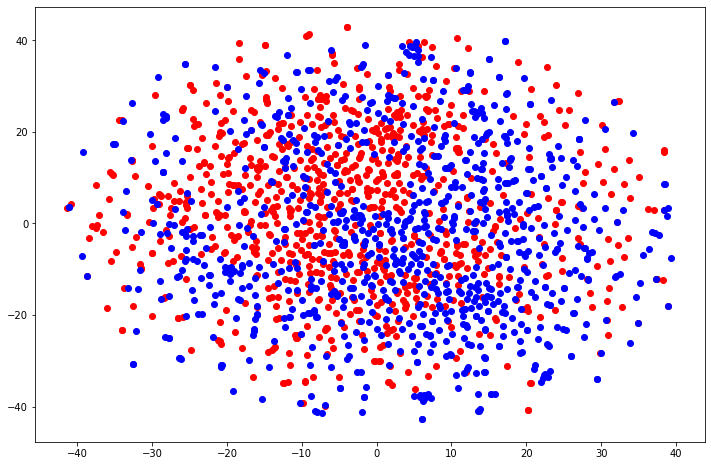

In [44]:
# 2d
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)

ax.scatter(embedding[np.where(np.array(vector_data.y_data) == 0), 0],\
           embedding[np.where(np.array(vector_data.y_data) == 0), 1],\
           color = 'r', label = '0')
ax.scatter(embedding[np.where(np.array(vector_data.y_data) == 1),0],\
           embedding[np.where(np.array(vector_data.y_data) == 1),1],\
           color = 'b', label = '1')

plt.show()

<IPython.core.display.Javascript object>


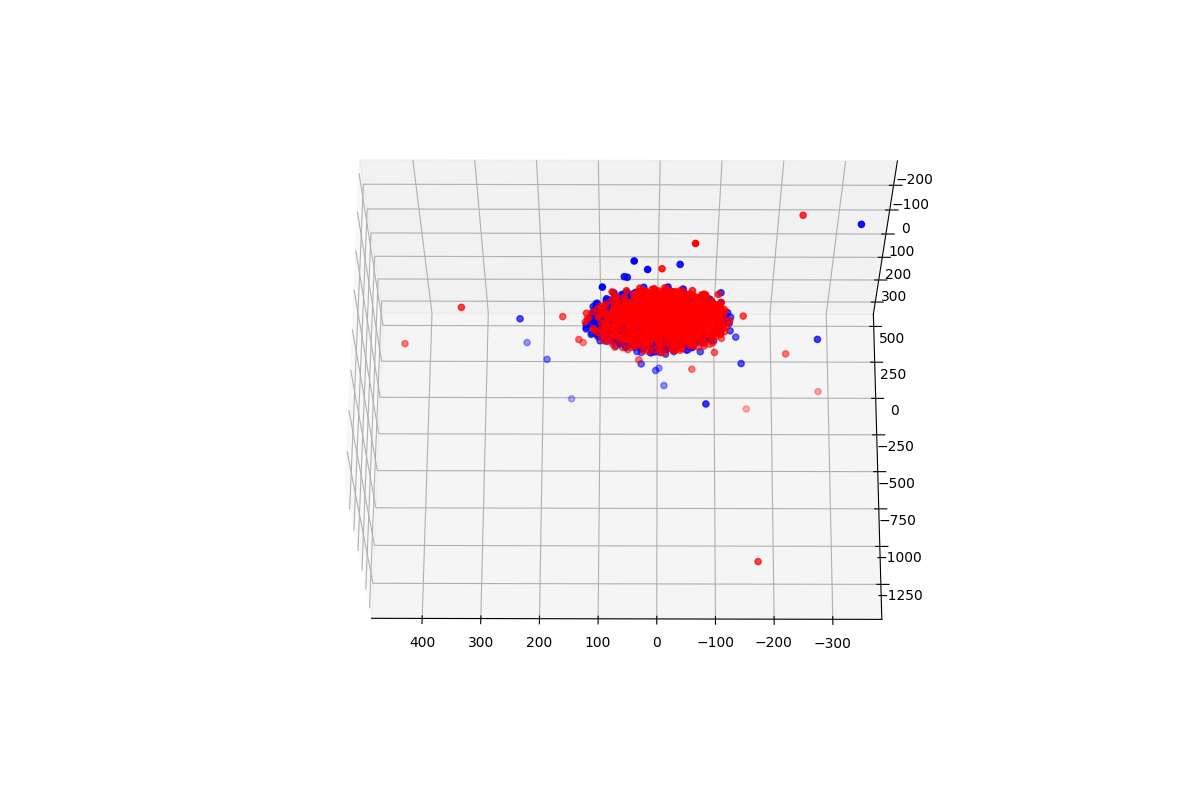

In [11]:
# 3d
%matplotlib notebook
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedding[np.where(np.array(vector_data.y_data) == 0), 0],\
           embedding[np.where(np.array(vector_data.y_data) == 0), 1],\
           embedding[np.where(np.array(vector_data.y_data) == 0), 2],\
           color = 'r', label = '0')
ax.scatter(embedding[np.where(np.array(vector_data.y_data) == 1),0],\
           embedding[np.where(np.array(vector_data.y_data) == 1),1],\
           embedding[np.where(np.array(vector_data.y_data) == 1),2],\
           color = 'b', label = '1')

plt.show()


In [16]:
tsne = TSNE(n_components=2)


blind_test      = DataHandler()
blind_test(test.x_train, test.y_train)

vector_data_test = DataHandler()
vector_data_test(DataHandler.applyDoc2Vec(blind_test.x_data, doc2vec_model.model), blind_test.y_data)

In [17]:
embedding = tsne.fit_transform(vector_data_test.x_data)

In [13]:
# predict
svm_model = MySVM(gamma=0.01, kernel = 'rbf')

svm_model.train(vector_data.x_data, vector_data.y_data)
predictions = svm_model.predict(DataHandler.applyDoc2Vec(test.x_train, doc2vec_model.model))

In [15]:
Metrics.getAccuracy(predictions, test.y_train)

0.835

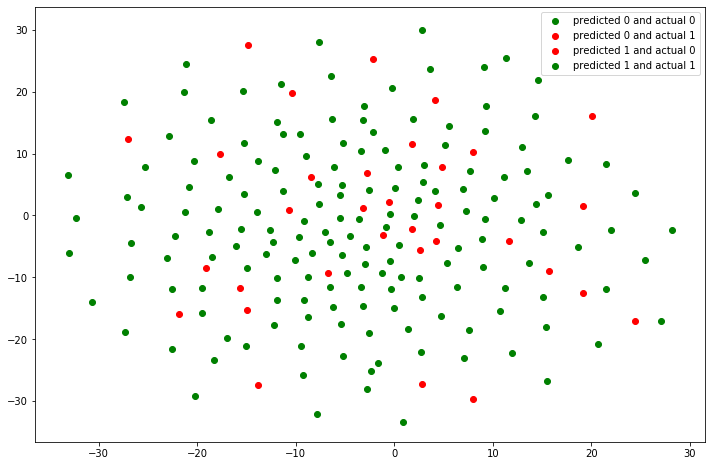

In [32]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)

ax.scatter(embedding[np.where((np.array(vector_data_test.y_data) == 0) & (np.array(predictions) == 0)), 0],\
           embedding[np.where((np.array(vector_data_test.y_data) == 0) & (np.array(predictions) == 0)), 1],\
           color = 'g', label = 'predicted 0 and actual 0')
ax.scatter(embedding[np.where((np.array(vector_data_test.y_data) == 1) & (np.array(predictions) == 0)), 0],\
           embedding[np.where((np.array(vector_data_test.y_data) == 1) & (np.array(predictions) == 0)), 1],\
           color = 'r', label = 'predicted 0 and actual 1')
ax.scatter(embedding[np.where((np.array(vector_data_test.y_data) == 0) & (np.array(predictions) == 1)), 0],\
           embedding[np.where((np.array(vector_data_test.y_data) == 0) & (np.array(predictions) == 1)), 1],\
           color = 'r', label = 'predicted 1 and actual 0')
ax.scatter(embedding[np.where((np.array(vector_data_test.y_data) == 1) & (np.array(predictions) == 1)), 0],\
           embedding[np.where((np.array(vector_data_test.y_data) == 1) & (np.array(predictions) == 1)), 1],\
           color = 'g', label = 'predicted 1 and actual 1')


ax.legend()
plt.show()

In [25]:
index_wrong_pred = np.where(((np.array(vector_data_test.y_data) == 1) & (np.array(predictions) == 0))) \
                            or ((np.array(vector_data_test.y_data) == 0) & (np.array(vector_data_test.y_data) == 0))

In [37]:
index_wrong_pred

(array([100, 105, 115, 116, 122, 126, 132, 142, 154, 156, 164, 166, 169,
        175, 197]),)

In [42]:
test.x_train[197]

['Starring',
 'Woody',
 'Allen',
 ',',
 'Alan',
 'Alda',
 ',',
 'Drew',
 'Barrymore',
 ',',
 'Lukas',
 'Haas',
 ',',
 'Goldie',
 'Hawn',
 ',',
 'Gaby',
 'Hoffman',
 ',',
 'Julia',
 'Roberts',
 ',',
 'Natasha',
 'Lyonne',
 ',',
 'Edward',
 'Norton',
 ',',
 'Natalie',
 'Portman',
 ',',
 'Tim',
 'Roth',
 'Starring',
 'Nicole',
 'Kidman',
 ',',
 'John',
 'Malkovich',
 ',',
 'Tate',
 'Donovan',
 ',',
 'Barbara',
 'Hershey',
 ',',
 'Mary-Louise',
 'Parker',
 ',',
 'Shelly',
 'Winters',
 'Adapted',
 'by',
 'Laura',
 'Jones',
 ',',
 'based',
 'on',
 'the',
 'novel',
 'by',
 'Henry',
 'James',
 'Directed',
 'by',
 'Jane',
 'Campion',
 'I',
 'can',
 'hear',
 'the',
 'question',
 'already',
 '.',
 'What',
 'on',
 'earth',
 'do',
 'these',
 'two',
 'movies',
 'have',
 'in',
 'common',
 '?',
 'To',
 'most',
 'people',
 ',',
 'not',
 'a',
 'lot',
 ',',
 'except',
 'that',
 'both',
 'are',
 'by',
 'renowned',
 'directors',
 '.',
 'As',
 'I',
 'saw',
 'them',
 ',',
 'however',
 ',',
 'both',
 'movies'

## Check if similar words are close together in doc2vec space


In [ ]:
#take all vocabulary (just unigrams)
#change every feature to a doc2vec vector
#plot as above

# BOW SVM


In [2]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data = DataHandler(file_dir)

our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

100%|██████████| 2000/2000 [00:01<00:00, 1792.37it/s]


In [3]:
vectorizer = TfidfVectorizer(ngram_range = (1,2))
collapsed_corpus = [' '.join(str(elem) for elem in doc) for doc in cv_train.x_data]
X = vectorizer.fit_transform(collapsed_corpus)

In [6]:
vocab = np.array([features for features in vectorizer.vocabulary_.keys()])
np.where(vocab == ".")

(array([], dtype=int64),)

In [55]:
my_svm = MySVM(kernel = 'rbf', gamma=0.002)
my_svm.train(X, cv_train.y_data)

In [59]:
collapsed_test = [' '.join(str(elem) for elem in doc) for doc in test.x_train]
X_test = vectorizer.transform(collapsed_test)
predictions = my_svm.predict(X_test)

In [61]:
Metrics.getAccuracy(predictions, test.y_train)

0.775

In [6]:
bow2vec_model = BoW2Vec([0,0], ['uni', 'bi'])

bow2vec_model.getFullVocab(cv_train)

vector_data = DataHandler()
vector_data(bow2vec_model.text2vec(cv_train), cv_train.y_data)


100%|██████████| 1800/1800 [00:10<00:00, 166.78it/s]


In [10]:
vocab2 = np.array([features for features in bow2vec_model.vocabulary])

In [11]:
len(vocab2)

489052

In [7]:
vector_data.x_data = sparse(np.array(vector_data.x_data))

In [4]:
vector_data.roundRobinSplit(10)

In [9]:
my_svm = MySVM(kernel = 'linear', gamma=0.01)
my_svm.train(vector_data.x_data, vector_data.y_data)

In [10]:
blind_test = DataHandler()
blind_test(test.x_train, test.y_train)

blind_test_vec = DataHandler()
blind_test_vec(bow2vec_model.text2vec(blind_test), blind_test.y_data)


100%|██████████| 200/200 [00:00<00:00, 222.12it/s]


In [92]:
blind_test_vec.x_data = sparse(np.array(blind_test_vec.x_data))

In [11]:
print(Metrics.getAccuracy(my_svm.predict(blind_test_vec.x_data), blind_test_vec.y_data))

0.845


In [ ]:
accuracies = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = 'rbf', C=1, cache_size=200, degree=3, gamma='auto',tol=0.001,shrinking=True, decision_function_shape = 'ovr')

  0%|          | 0/10 [00:00<?, ?it/s]

## optimize threshold params


In [22]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data = DataHandler(file_dir)

our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

bow2vec_model = BoW2Vec([eta1,eta2], ['uni', 'bi'])
bow2vec_model.getFullVocab(cv_train)

vector_data = DataHandler()
vector_data(bow2vec_model.text2vec(cv_train), cv_train.y_data)
#vector_data.x_data = sparse(np.array(vector_data.x_data))
vector_data.roundRobinSplit(10)
vector_data.sparse = True
        
accuracy = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = 'linear', gamma=0.01)
mean_acc = np.mean(np.array(accuracy))
sd = 2*np.sqrt(np.var(np.array(accuracy)))

print(str(mean_acc) + str(' +- ') + str(sd))






  0%|          | 0/2000 [00:00<?, ?it/s]




  2%|▏         | 37/2000 [00:00<00:05, 364.59it/s]




  6%|▌         | 117/2000 [00:00<00:04, 434.93it/s]




 12%|█▏        | 231/2000 [00:00<00:03, 533.90it/s]




 16%|█▌        | 314/2000 [00:00<00:02, 579.64it/s]




 22%|██▏       | 432/2000 [00:00<00:02, 683.76it/s]




 28%|██▊       | 567/2000 [00:00<00:01, 802.20it/s]




 35%|███▌      | 700/2000 [00:00<00:01, 910.31it/s]




 42%|████▏     | 838/2000 [00:00<00:01, 1012.88it/s]




 49%|████▉     | 989/2000 [00:00<00:00, 1123.86it/s]




 59%|█████▊    | 1172/2000 [00:01<00:00, 1270.97it/s]




 68%|██████▊   | 1366/2000 [00:01<00:00, 1417.59it/s]




 77%|███████▋  | 1542/2000 [00:01<00:00, 1504.71it/s]




 87%|████████▋ | 1731/2000 [00:01<00:00, 1601.13it/s]




100%|██████████| 2000/2000 [00:01<00:00, 1317.98it/s]





  0%|          | 0/1782 [00:00<?, ?it/s]




  3%|▎         | 51/1782 [00:00<00:03, 499.07it/s]




  6%|▌         | 101/1782 [00:00<00:03, 498.52it/s]




0.839325842697 +- 0.0318594311882


In [3]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data = DataHandler(file_dir)

our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

accuracies = {}
for eta1 in [0,4,8,12]:
    for eta2 in [0,4,8,12]:
        print(eta1, eta2)
        bow2vec_model = BoW2Vec([eta1,eta2], ['uni', 'bi'])
        bow2vec_model.getFullVocab(cv_train)

        vector_data = DataHandler()
        vector_data(bow2vec_model.text2vec(cv_train), cv_train.y_data)
        #vector_data.x_data = sparse(np.array(vector_data.x_data))
        vector_data.roundRobinSplit(10)
        vector_data.sparse = True
        
        accuracy = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = 'linear', gamma=0.01)
        mean_acc = np.mean(np.array(accuracy))
        sd = 2*np.sqrt(np.var(np.array(accuracy)))
        
        accuracies['eta1={},eta2={}'.format(eta1,eta2)] = str(mean_acc) + str(" +- ") + str(sd)
        

100%|██████████| 2008/2008 [00:00<00:00, 2149.78it/s]


0 4


100%|██████████| 10/10 [03:44<00:00, 22.45s/it]


0 8


100%|██████████| 10/10 [03:16<00:00, 19.63s/it]


0 12


100%|██████████| 10/10 [03:00<00:00, 18.03s/it]


4 4


100%|██████████| 10/10 [03:28<00:00, 20.83s/it]


4 8


100%|██████████| 10/10 [03:00<00:00, 18.04s/it]


4 12


100%|██████████| 10/10 [02:55<00:00, 17.59s/it]


8 4


100%|██████████| 10/10 [03:35<00:00, 21.53s/it]


8 8


100%|██████████| 10/10 [02:56<00:00, 17.64s/it]


8 12


100%|██████████| 10/10 [02:41<00:00, 16.16s/it]


## optimize svm params

In [2]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data = DataHandler(file_dir)

our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

bow2vec_model = BoW2Vec([4,4], ['uni', 'bi'])
bow2vec_model.getFullVocab(cv_train)

vector_data = DataHandler()
vector_data(bow2vec_model.text2vec(cv_train), cv_train.y_data)
vector_data.roundRobinSplit(10)
vector_data.sparse = True
accuracies = {}
for iterations in [1000, 5000, 8000]:
    for kernel in ['linear', 'poly', 'rbf']:
        for gamma in ['scale', 'auto', 0.001, 0.002, 0.005]:
            if kernel == 'poly' and gamma != 'scale':
                continue
            for degree in [2, 3, 5]:
                if kernel != 'poly' and degree != 2:
                    continue
                print(kernel, gamma, degree)
                
                if kernel == 'linear' and gamma == 'auto':
                    continue
                if kernel == 'linear' and type(gamma) != int:
                    accuracy = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = kernel, degree = degree, max_iter=iterations)
                else:   
                    accuracy = Metrics.roundRobinCV(vector_data,10,MySVM,kernel=kernel,gamma=gamma,degree=degree,max_iter=iterations)

                mean_acc = np.mean(np.array(accuracy))
                sd = 2*np.sqrt(np.var(np.array(accuracy)))

                accuracies['iter={},kernel={},gamma={},degree={}'.format(iterations, kernel, gamma, degree)] = str(mean_acc) + str(" +- ") + str(sd)


  0%|          | 0/10 [00:00<?, ?it/s]

linear scale 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:17<02:40, 17.85s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:35<02:23, 17.88s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:52<02:03, 17.65s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear auto 2
linear 0.001 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:16<02:26, 16.33s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:32<02:11, 16.41s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:48<01:54, 16.29s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear 0.002 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:17<02:41, 17.99s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:35<02:22, 17.86s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:52<02:02, 17.51s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear 0.005 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:17<02:40, 17.82s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:35<02:21, 17.64s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:51<02:00, 17.22s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

poly scale 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:21<03:13, 21.48s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:43<02:52, 21.51s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:04<02:29, 21.36s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

poly scale 3


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:21<03:14, 21.58s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:43<02:53, 21.65s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:03<02:29, 21.32s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

poly scale 5


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:21<03:13, 21.50s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:42<02:49, 21.23s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:02<02:27, 21.03s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

rbf scale 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:22<03:24, 22.69s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:45<03:02, 22.75s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:10<02:43, 23.40s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

rbf auto 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.001 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:26<03:55, 26.21s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:52<03:29, 26.20s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:18<03:04, 26.32s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

rbf 0.002 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:26<04:00, 26.73s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:52<03:32, 26.53s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:18<03:04, 26.35s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

rbf 0.005 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:25<03:50, 25.62s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:52<03:28, 26.03s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:20<03:07, 26.72s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear scale 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:22<03:26, 22.99s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:40<02:51, 21.47s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:58<02:21, 20.18s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear auto 2
linear 0.001 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:23<03:27, 23.10s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:41<02:53, 21.67s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:59<02:24, 20.60s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear 0.002 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:22<03:21, 22.38s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:40<02:48, 21.02s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [00:57<02:19, 19.92s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

linear 0.005 2


/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 10%|█         | 1/10 [00:22<03:21, 22.36s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 20%|██        | 2/10 [00:41<02:51, 21.48s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 30%|███       | 3/10 [01:00<02:24, 20.67s/it]/Users/igoradamski/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWar

poly scale 2


  0%|          | 0/10 [00:00<?, ?it/s]

poly scale 3


  0%|          | 0/10 [00:00<?, ?it/s]

poly scale 5


  0%|          | 0/10 [00:00<?, ?it/s]

rbf scale 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf auto 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.001 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.002 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.005 2


  0%|          | 0/10 [00:00<?, ?it/s]

linear scale 2


  0%|          | 0/10 [00:00<?, ?it/s]

linear auto 2
linear 0.001 2


  0%|          | 0/10 [00:00<?, ?it/s]

linear 0.002 2


  0%|          | 0/10 [00:00<?, ?it/s]

linear 0.005 2


  0%|          | 0/10 [00:00<?, ?it/s]

poly scale 2


  0%|          | 0/10 [00:00<?, ?it/s]

poly scale 3


  0%|          | 0/10 [00:00<?, ?it/s]

poly scale 5


  0%|          | 0/10 [00:00<?, ?it/s]

rbf scale 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf auto 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.001 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.002 2


  0%|          | 0/10 [00:00<?, ?it/s]

rbf 0.005 2


100%|██████████| 10/10 [04:18<00:00, 25.86s/it]


In [6]:
1/(len(vector_data.x_data[0])*0.104)

0.00016233702985572786

In [5]:
np.var(vector_data.x_data)

0.10485586878165232

In [3]:
accuracies

{'iter=1000,kernel=linear,gamma=0.001,degree=2': '0.8516666666666668 +- 0.05534404180183233',
 'iter=1000,kernel=linear,gamma=0.002,degree=2': '0.8516666666666668 +- 0.05534404180183233',
 'iter=1000,kernel=linear,gamma=0.005,degree=2': '0.8516666666666668 +- 0.05534404180183233',
 'iter=1000,kernel=linear,gamma=scale,degree=2': '0.8516666666666668 +- 0.05534404180183233',
 'iter=1000,kernel=poly,gamma=scale,degree=2': '0.7211111111111111 +- 0.06513044839890154',
 'iter=1000,kernel=poly,gamma=scale,degree=3': '0.685 +- 0.07010574024154378',
 'iter=1000,kernel=poly,gamma=scale,degree=5': '0.6538888888888889 +- 0.07982233358071915',
 'iter=1000,kernel=rbf,gamma=0.001,degree=2': '0.7333333333333334 +- 0.053518198127965766',
 'iter=1000,kernel=rbf,gamma=0.002,degree=2': '0.6283333333333334 +- 0.07832348243812044',
 'iter=1000,kernel=rbf,gamma=0.005,degree=2': '0.5233333333333332 +- 0.0435464843161454',
 'iter=1000,kernel=rbf,gamma=auto,degree=2': '0.6733333333333335 +- 0.063401522745276',


## optimize SVM params for Doc2Vec



In [10]:
file_dir = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
data = DataHandler(file_dir)
our_data      = DataHandler(file_dir)
our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

blind_test = DataHandler()
blind_test(test.x_train, test.y_train)

model_path = '/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/doc2vec_models/'

model_name = 'model_dm=0,hs=1,min_count=10,vector_size=50,window=5.bin'

doc2vec_model = MyDoc2Vec()
doc2vec_model.load(model_path+model_name)

vector_data = DataHandler()
vector_data(DataHandler.applyDoc2Vec(cv_train.x_data, doc2vec_model.model), cv_train.y_data)

vector_data_test = DataHandler()
vector_data_test(DataHandler.applyDoc2Vec(blind_test.x_data, doc2vec_model.model), blind_test.y_data)

vector_data.roundRobinSplit(10)

100%|██████████| 2000/2000 [00:00<00:00, 2219.74it/s]


In [15]:
results = {}
for kernel in ['linear', 'rbf', 'poly']:
    for gamma in [0.1, 0.001, 'scale', 'auto']:
        for degree in [2,3,5]:
            if kernel == 'linear' and gamma != 0.1 and degree != 2:
                continue
            if kernel == 'rbf' and degree != 2:
                continue
                
            if kernel == 'linear':
                my_svm = MySVM(kernel = kernel)
                cv_acc = Metrics.roundRobinCV(vector_data, 10, MySVM, kernel = 'linear')
            if kernel == 'rbf':
                my_svm = MySVM(kernel = kernel, gamma = gamma)
                cv_acc = Metrics.roundRobinCV(vector_data, 10, MySVM, gamma=gamma, kernel = 'rbf')
            if kernel == 'poly':
                my_svm = MySVM(kernel = kernel, gamma = gamma, degree = degree)
                cv_acc = Metrics.roundRobinCV(vector_data, 10, MySVM, gamma=gamma, degree=degree, kernel = 'poly')
            
            my_svm.train(vector_data.x_data, vector_data.y_data)
            predictions = my_svm.predict(vector_data_test.x_data)
            
            results['kernel={},gamma={},degree={}'.format(kernel, gamma, degree)] = [np.mean(np.array(cv_acc)), \
                                                                                    Metrics.getAccuracy(predictions, vector_data_test.y_data)]
            

100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


In [16]:
results

{'kernel=linear,gamma=0.001,degree=2': [0.8877777777777778, 0.82],
 'kernel=linear,gamma=0.1,degree=2': [0.8877777777777778, 0.82],
 'kernel=linear,gamma=0.1,degree=3': [0.8877777777777778, 0.82],
 'kernel=linear,gamma=0.1,degree=5': [0.8877777777777778, 0.82],
 'kernel=linear,gamma=auto,degree=2': [0.8877777777777778, 0.82],
 'kernel=linear,gamma=scale,degree=2': [0.8877777777777778, 0.82],
 'kernel=poly,gamma=0.001,degree=2': [0.8322222222222221, 0.775],
 'kernel=poly,gamma=0.001,degree=3': [0.8355555555555556, 0.76],
 'kernel=poly,gamma=0.001,degree=5': [0.5583333333333333, 0.53],
 'kernel=poly,gamma=0.1,degree=2': [0.8816666666666666, 0.835],
 'kernel=poly,gamma=0.1,degree=3': [0.8811111111111112, 0.83],
 'kernel=poly,gamma=0.1,degree=5': [0.8738888888888889, 0.81],
 'kernel=poly,gamma=auto,degree=2': [0.8666666666666668, 0.79],
 'kernel=poly,gamma=auto,degree=3': [0.8355555555555556, 0.76],
 'kernel=poly,gamma=auto,degree=5': [0.5583333333333333, 0.53],
 'kernel=poly,gamma=scale,d

# Analyze hyperparam results

In [1]:
import pandas as pd
dataset=pd.read_csv("optimisation_results.txt",delimiter=",", header=None)

In [2]:
dataset[5] = dataset[5].map(lambda x: x.strip('^accuracy='))
dataset[6] = dataset[6].map(lambda x: x.strip('^cv_acc='))

In [3]:
dataset.sort_values(6, ascending=False)

,0,1,2,3,4,5,6
35,model_dm=0,hs=1,min_count=10,vector_size=100,window=5,0.9343434343434344,0.8668539325842698
21,model_dm=0,hs=1,min_count=1,vector_size=100,window=1,0.8939393939393939,0.8634831460674158
28,model_dm=0,hs=1,min_count=5,vector_size=100,window=2,0.9343434343434344,0.8634831460674157
29,model_dm=0,hs=1,min_count=5,vector_size=100,window=5,0.9141414141414141,0.8629213483146068
17,model_dm=0,hs=0,min_count=10,vector_size=100,window=5,0.9141414141414141,0.8623595505617978
33,model_dm=0,hs=1,min_count=10,vector_size=100,window=1,0.9292929292929293,0.8617977528089888
27,model_dm=0,hs=1,min_count=5,vector_size=100,window=1,0.9242424242424242,0.8617977528089888
16,model_dm=0,hs=0,min_count=10,vector_size=100,window=2,0.8939393939393939,0.8612359550561799
26,model_dm=0,hs=1,min_count=5,vector_size=50,window=5,0.9040404040404041,0.8606741573033709
24,model_dm=0,hs=1,min_count=5,vector_size=50,window=1,0.9040404040404041,0.8601123595505618


In [14]:
dataset[dataset[0] == 'model_dm=1']

,0,1,2,3,4,5,6
36,model_dm=1,hs=0,min_count=1,vector_size=50,window=1,0.8383838383838383,0.7859550561797752
37,model_dm=1,hs=0,min_count=1,vector_size=50,window=2,0.8535353535353535,0.7775280898876404
38,model_dm=1,hs=0,min_count=1,vector_size=50,window=5,0.8434343434343434,0.7780898876404494
39,model_dm=1,hs=0,min_count=1,vector_size=100,window=1,0.8737373737373737,0.805056179775281
40,model_dm=1,hs=0,min_count=1,vector_size=100,window=2,0.8737373737373737,0.8067415730337079
41,model_dm=1,hs=0,min_count=1,vector_size=100,window=5,0.8888888888888888,0.8101123595505617
42,model_dm=1,hs=0,min_count=5,vector_size=50,window=1,0.8333333333333334,0.7882022471910112
43,model_dm=1,hs=0,min_count=5,vector_size=50,window=2,0.8434343434343434,0.7910112359550562
44,model_dm=1,hs=0,min_count=5,vector_size=50,window=5,0.8585858585858586,0.793258426966292
45,model_dm=1,hs=0,min_count=5,vector_size=100,window=1,0.8686868686868687,0.8151685393258428


In [12]:
dataset = dataset.apply(lambda x: x.str.strip() if x.dtype == "object" else x)